### Проект выполнил
Ф.И.О Мирошкин Ярослав Андреевич <br>
Telegram - https://t.me/MiroshkinYaroslav

## Описание проекта

## Цели

## Описание данных

# English Score


In [50]:
import os
import pysrt as srt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
import spacy
import pickle
import pprint
import re

import lightgbm as lgb

import nltk
from nltk.corpus import stopwords

from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV


nltk.download('stopwords')
nltk.download('punkt')

STATE = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(cm)
    cmp.plot()


### Парсинг данных и чтение данных

In [2]:
movies_labels = pd.read_excel('english_scores\movies_labels.xlsx', index_col='Movie').drop('id', axis=1)
paths = ['english_scores/subtitles_all/subtitles/',
         'english_scores/subtitles_all/A2/',
         'english_scores/subtitles_all/B1/',
         'english_scores/subtitles_all/B2/',
         'english_scores/subtitles_all/C1/',
         'subtitles/']
data = {}
for path in paths:
    for sub_name in os.listdir(path[:-1]):
        try:
            subs = srt.open(path + sub_name, encoding='utf-8')
        except:
            subs = srt.open(path + sub_name, encoding='ISO-8859-1')
        sub_list = " ".join([sub.text for sub in subs])
        data[sub_name[:-4]] = sub_list


In [3]:
df = pd.DataFrame(data.values(), index=data.keys(), columns=['subtitle'])
df.head(3)

,subtitle
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz..."
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here..."
Aladdin(1992),"<i>Oh, I come from a land\nFrom a faraway plac..."


Получен датасет, где:<br>
индексы - названия фильмов<br>
subtitle - субтитры в строков формате <br><br>
Оценим общее количество символов в "сыром датасете"

In [5]:
print(f'Общее количество символов в субтитрах: {df.subtitle.str.len().sum():,.0f}')

Общее количество символов в субтитрах: 11,277,626


### Добавление и обработка разметки

Добавим в датасет разметку

In [6]:
movies_labels.head(3)

,Level
Movie,
10_Cloverfield_lane(2016),B1
10_things_I_hate_about_you(1999),B1
A_knights_tale(2001),B2


In [7]:
print(f'Количество файлов субтитров: {df.subtitle.count()}\n\
Количество строк в разметке: {movies_labels.Level.count()}')

Количество файлов субтитров: 279
Количество строк в разметке: 241


Часть данных не размечена

In [8]:
df = df.join(movies_labels)
df = df.rename(columns={'Level': 'level'})
df.head(2)

,subtitle,level
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz...",B1
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here...",B1


Проанализируем баланс классов в `level`

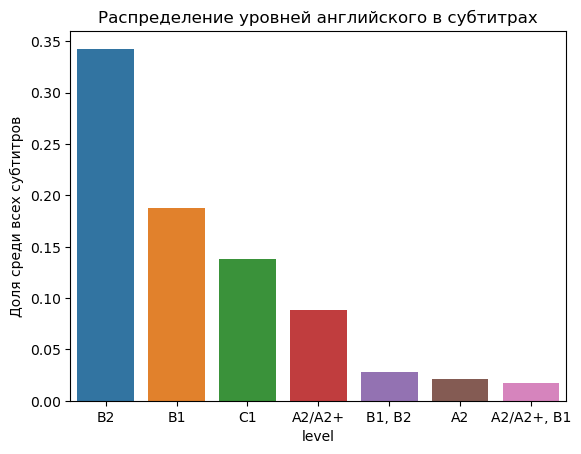

In [9]:
level_distribution = df.level.value_counts(dropna=False, normalize=True)
sns.barplot(x=level_distribution.index,
             y=level_distribution.values)\
                .set(title='Распределение уровней английского в субтитрах', \
                     ylabel='Доля среди всех субтитров');

Оставим 4 основных уровня знания языка:
* A2, A2+ - Beginner, Elementary 
* B1 - Intermediate 
* B2 - Upper-Intermediate 
* C1 - Advanced


In [10]:
df = df.replace({'level' :{'B1, B2': 'B1',
                      'A2': 'A2/A2+',
                      'A2/A2+, B1': 'A2/A2+'}})

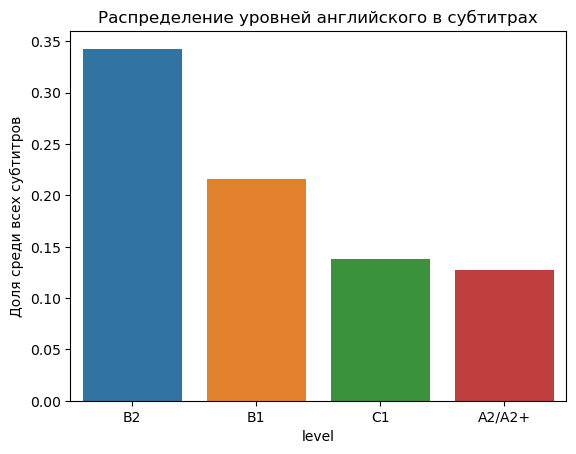

In [11]:
new_level_distribution = df.level.value_counts(dropna=False, normalize=True)
sns.barplot(x=new_level_distribution.index,
             y=new_level_distribution.values)\
                .set(title='Распределение уровней английского в субтитрах', \
                     ylabel='Доля среди всех субтитров');

Присутствует дисбаланс классов <br><br>
Удалим неразмеченные данные

In [12]:
df = df.dropna(subset='level', axis=0)

Заменим уровни знания языка числовыми параметрами в порядке возрастания.
* A2, A2+ - 0
* B1 - 1
* B2 - 2 
* C1 - 3

In [13]:
df.level = df.level.replace({'A2/A2+': 0,
                  'B1': 1,
                  'B2': 2,
                  'C1': 3})

### Обработка данных

#### Приведение к нижнему регистру, обработка спецсимволов и "стоп-слов"

In [14]:
# Пример "стоп-слов"
np.array(stopwords.words('english'))[:20]

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his'], dtype='<U10')

In [15]:
def preprocess_text(data, stopwords=stopwords.words('english')):
    #Приводим к нижему регистру
    text = data.lower()
    #Удаляем все символы между <>, '<some symbols>' -> ''
    text = re.sub('<[^>]+>', '', text)
    #Добавляем пробелы между знаками препинания
    text = re.sub(r"([.,!?])", r" \1 ", text)
    # удаляем пробелы в начале и в конце предложения
    text = text.strip()
    #Удаляем слова в скобках
    text = re.sub(r'\([^)]*\)', '', text)
    # Оставляем только латинские буквы
    text = re.sub(r'[^a-z]', ' ', text)
    
    # удаление стоп-слов
    text = [w for w in text.split() if w not in stopwords]
    # удаляем слова короче 3х символов
    text = [w for w in text if len(w) >= 3]
    return ' '.join(text)

In [16]:
df.subtitle = df.subtitle.apply(lambda text: preprocess_text(text))

#### Стемминг и лемматизация

In [17]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [18]:
flag = 0
if flag:
    df['lemma_clear_text'] = df.subtitle.apply(lambda row: lemmatize(row))
else:
    with open('df_lemma.pickle', 'rb') as file:
        df = pickle.load(file)

In [19]:
features = df.lemma_clear_text
target = df.level

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target,\
                                 test_size=0.25, random_state=STATE, shuffle=True)

In [21]:
y_train

Despicable_Me(2010)                                         2
The_Fundamentals_of_Caring(2016)                            1
Knives_out(2019)                                            2
Cast_away(2000)                                             0
SOMM.Into.the.Bottle.2015.1080p.BluRay.x265-RARBG.en.srt    2
                                                           ..
Home_alone(1990)                                            1
The Walking Dead-S01E05-Wildfire.English                    0
Suits S04E01 EngSub                                         3
Downton Abbey - S01E01 - Episode 1.eng.SDH                  3
Suits.S02E12.HDTV.x264-ASAP                                 2
Name: level, Length: 174, dtype: int64

### Векторизация

In [39]:
corpus_train = X_train.values
corpus_test = X_test.values

In [40]:
tfidf = TfidfVectorizer()
tf_idf_train = tfidf.fit_transform(corpus_train)
tf_idf_test = tfidf.transform(corpus_test)

### Моделирование

LogisticRegression Baseline

In [41]:
lr = LogisticRegression(random_state=STATE, class_weight='balanced')
lr.fit(tf_idf_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

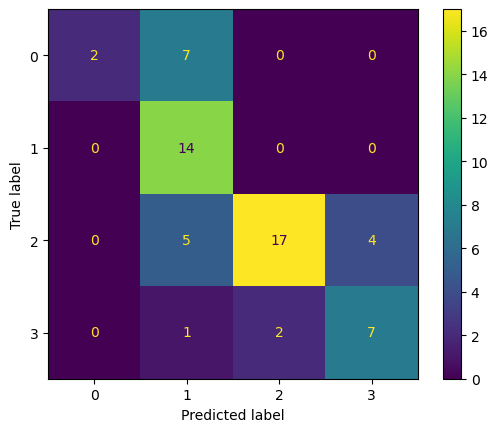

In [42]:
plot_confusion_matrix(y_test, lr.predict(tf_idf_test))

In [43]:
print(classification_report(y_test, lr.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.52      1.00      0.68        14
           2       0.89      0.65      0.76        26
           3       0.64      0.70      0.67        10

    accuracy                           0.68        59
   macro avg       0.76      0.64      0.62        59
weighted avg       0.78      0.68      0.66        59



LogisticRegression Tuning

RandomForestClassifier Tuning

In [44]:
rfc = RandomForestClassifier(random_state=STATE, max_depth=15)
rfc.fit(tf_idf_train, y_train);

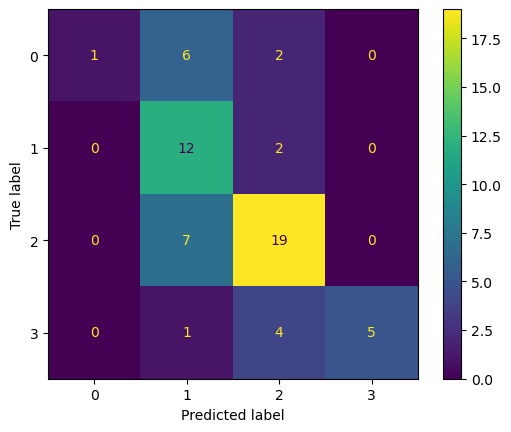

In [45]:
plot_confusion_matrix(y_test, y_pred=rfc.predict(tf_idf_test))

In [46]:
print(classification_report(y_test, y_pred=rfc.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.46      0.86      0.60        14
           2       0.70      0.73      0.72        26
           3       1.00      0.50      0.67        10

    accuracy                           0.63        59
   macro avg       0.79      0.55      0.55        59
weighted avg       0.74      0.63      0.60        59



LightGBM Tuning|

In [47]:
lgb_model = lgb.LGBMClassifier(random_state=STATE)
lgb_model.fit(tf_idf_train, y_train)

LGBMClassifier(random_state=0)

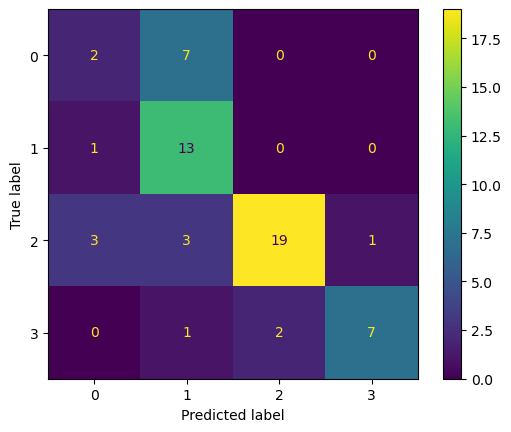

In [48]:
plot_confusion_matrix(y_test, lgb_model.predict(tf_idf_test))

In [49]:
print(classification_report(y_test, lgb_model.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.33      0.22      0.27         9
           1       0.54      0.93      0.68        14
           2       0.90      0.73      0.81        26
           3       0.88      0.70      0.78        10

    accuracy                           0.69        59
   macro avg       0.66      0.65      0.63        59
weighted avg       0.73      0.69      0.69        59



CatBoostClassifier

In [ ]:
flag = 0
if flag:
    cbc = CatBoostClassifier(random_state=STATE, max_depth=10, iterations=100)
    cbc.fit(tf_idf_train, y_train)
else:
    with open('cbc.pickle', 'rb') as file:
        cbc = pickle.load(file)

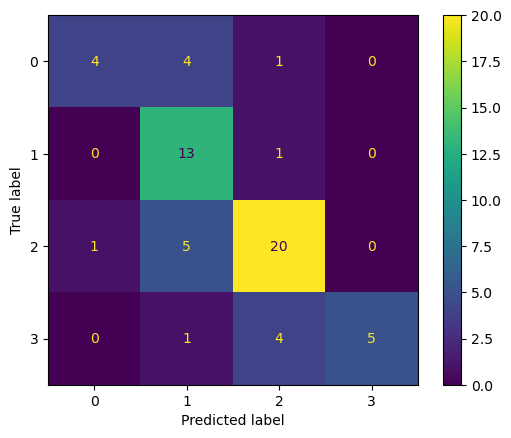

In [56]:
plot_confusion_matrix(y_test, cbc.predict(tf_idf_test))

In [54]:
print(classification_report(y_test, cbc.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.57      0.93      0.70        14
           2       0.77      0.77      0.77        26
           3       1.00      0.50      0.67        10

    accuracy                           0.71        59
   macro avg       0.78      0.66      0.68        59
weighted avg       0.76      0.71      0.71        59

